Comparing the performance of FiveThirtyEight's 2017 season MLB predictions (https://projects.fivethirtyeight.com/2017-mlb-predictions/games/) against best execution prices across exchanges on UK sportsbooks.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
%matplotlib inline

### load data (result of pony.orm query on a MySql DB containing sportsbook prices from multiple exchanges, 538 predictions and game data from mlMLBb API)

In [31]:
data = pd.read_csv('./mlb.csv')

### view schema

In [32]:
data.head()

,id,homeTeamId,awayTeamId,homeTeamRuns,awayTeamRuns,homeTeamWin,date,awayName,homeName,538home,538away,exchangeHomePrice,bestHomeExchangeId,exchangeAwayPrice,bestAwayExchangeId
0,1,2,30,2.0,1.0,1.0,2017-04-17,Pittsburgh Pirates,St. Louis Cardinals,0.51,0.49,0.75,1,1.10,1.0
1,2,10,5,7.0,4.0,1.0,2017-04-17,Chicago White Sox,New York Yankees,0.56,0.44,0.62,1,1.35,1.0
2,3,25,17,5.0,4.0,1.0,2017-04-17,San Diego Padres,Atlanta Braves,0.55,0.45,0.62,1,1.38,1.0
3,4,1,3,3.0,6.0,0.0,2017-04-17,Milwaukee Brewers,Chicago Cubs,0.65,0.35,0.50,1,1.63,1.0
4,5,4,27,3.0,0.0,1.0,2017-04-17,Los Angeles Angels,Houston Astros,0.60,0.40,0.62,1,1.35,1.0


exchangeHomePrice, exchangeAwayPrice represent the best price (i.e. longest odds, 
or equivalently lowest predicted % win) across multiple exchanges.
Prices were collected at 12pm on game day (so we're not considering bet timing below, or information risk which may exist if 538 predictions published before news which impacts the line).

In [33]:
data.describe()

,id,homeTeamId,awayTeamId,homeTeamRuns,awayTeamRuns,homeTeamWin,538home,538away,exchangeHomePrice,bestHomeExchangeId,exchangeAwayPrice,bestAwayExchangeId
count,1276.000000,1276.000000,1276.000000,1236.000000,1236.000000,1236.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1275.000000
mean,2780.189655,15.558777,15.396552,4.847896,4.614078,0.557443,0.525666,0.464929,0.865071,2.036050,1.114585,2.232941
std,1694.359308,8.637655,8.734037,3.231851,3.181540,0.496890,0.090797,0.087592,0.314879,0.565922,0.384961,0.826284
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.260000,1.000000,0.290000,1.000000
25%,344.750000,8.000000,8.000000,2.000000,2.000000,0.000000,0.480000,0.410000,0.650000,2.000000,0.830000,2.000000
50%,3644.500000,16.000000,15.000000,4.000000,4.000000,1.000000,0.530000,0.470000,0.800000,2.000000,1.050000,2.000000
75%,4030.250000,23.000000,23.000000,7.000000,6.000000,1.000000,0.580000,0.520000,1.000000,2.000000,1.350000,2.000000
max,4462.000000,30.000000,30.000000,20.000000,22.000000,1.000000,0.750000,0.700000,2.700000,4.000000,3.250000,4.000000


### transformation utility methods

In [34]:
def convertDecimalOddsToPercent(decimalOdds): 
    return 1 / (1 + decimalOdds)

def customRound(x, base=5):
    return int(base * round(float(x) / base))

In [35]:
# need consistent price format
data['exchangeHomePercent'] = convertDecimalOddsToPercent(data['exchangeHomePrice'])
data['exchangeAwayPercent'] = convertDecimalOddsToPercent(data['exchangeAwayPrice'])

In [36]:
# check for missing results - count homeTeamWin < 528away in the above suggests some results are missing
countMissingResults = len(data[data.homeTeamWin.notnull()])

In [37]:
# remove missing results
data = data[data['homeTeamWin'].notnull()]
data = data[data['538home'] > 0]
len(data)

1224

### visualise

### average spread

In [38]:
data['spread'] = data['exchangeHomePercent'] + data['exchangeAwayPercent'] - 1
# assume negative spread is an error. separate analysis for defining genuine arb opportunities
data = data[data['spread'] > 0]

In [39]:
data['spread'].describe()

count    1217.000000
mean        0.038148
std         0.008296
min         0.001462
25%         0.032911
50%         0.039341
75%         0.044372
max         0.083839
Name: spread, dtype: float64

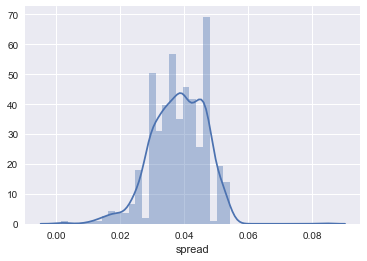

In [40]:
sns.distplot(data['spread'])

### read prices for single sportsbook to assess improvement in spread achievable through sourcing best prices from multiple books

In [41]:
single_exchange = pd.read_csv('single_exchange.csv')

In [42]:
single_exchange.describe()

,id,awayPrice,homePrice,exchangeId,gameId
count,1266.000000,1266.000000,1266.000000,1266.0,1266.000000
mean,1637.394155,1.100158,0.865766,2.0,3002.075039
std,646.929435,0.378182,0.315359,0.0,1610.270703
min,576.000000,0.290000,0.260000,2.0,65.000000
25%,1223.250000,0.830000,0.650000,2.0,3336.250000
50%,1620.500000,1.050000,0.800000,2.0,3705.500000
75%,1959.750000,1.350000,1.000000,2.0,4090.750000
max,3034.000000,3.000000,2.700000,2.0,4544.000000


In [43]:
single_exchange['homePercent'] = convertDecimalOddsToPercent(single_exchange['homePrice'])
single_exchange['awayPercent'] = convertDecimalOddsToPercent(single_exchange['awayPrice'])
single_exchange['spread'] = single_exchange['homePercent'] + single_exchange['awayPercent'] - 1
# assume negative spread is an error. separate analysis for defining genuine arb opportunities
single_exchange = single_exchange[single_exchange['spread'] > 0]

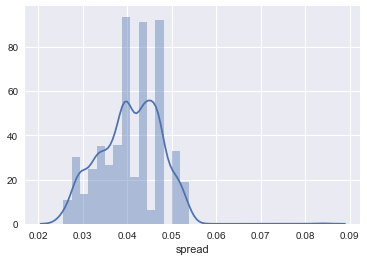

In [44]:
sns.distplot(single_exchange['spread'])

In [45]:
single_exchange['spread'].describe()

count    1264.000000
mean        0.040672
std         0.006675
min         0.025641
25%         0.036160
50%         0.039829
75%         0.046448
max         0.083839
Name: spread, dtype: float64

Broadly a linear shift down 0.2% for this single exchange versus best execution. of course, best exchange price is never worse than that from any single exchange, though improved execution price will contribute to beating spread in addition to any delta in predictive power.

### dist of 538 home %

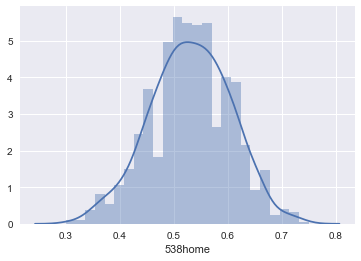

In [46]:
sns.distplot(data['538home'])

In [47]:
data['538home'].describe()

count    1217.000000
mean        0.530575
std         0.074808
min         0.300000
25%         0.480000
50%         0.530000
75%         0.580000
max         0.750000
Name: 538home, dtype: float64

In [48]:
np.std(data['538home'])

0.07477711263495568

### dist of best exchange home %

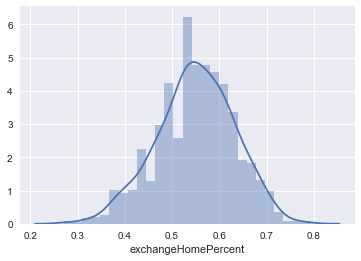

In [49]:
sns.distplot(data['exchangeHomePercent'])

In [50]:
data['exchangeHomePercent'].describe()

count    1217.000000
mean        0.549657
std         0.082263
min         0.270270
25%         0.500000
50%         0.555556
75%         0.606061
max         0.793651
Name: exchangeHomePercent, dtype: float64

In [51]:
np.std(data['exchangeHomePercent'])

0.0822292926062244

pretty similar, 538 dist a little tighter and favours home team slightly less. we don't see much edge here

In [52]:
### ROC curve for 538 predictions vs predictions implied by best exchange prices
### where 'best prices' means lowest % prediction available across exchanges
### how well does 538 perform against the best price prediction

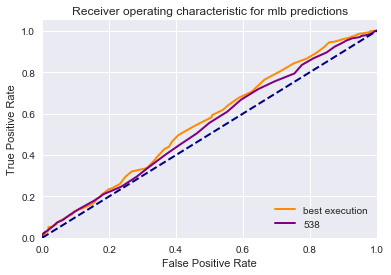

In [53]:
Y = data['homeTeamWin']
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[0], tpr[0], _ = metrics.roc_curve(Y, data['exchangeHomePercent'])
fpr[1], tpr[1], _ = metrics.roc_curve(Y, data['538home'])
roc_auc[0] = metrics.auc(fpr[0], tpr[0])
roc_auc[1] = metrics.auc(fpr[1], tpr[1])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='best execution')
plt.plot(fpr[1], tpr[1], color='purple',
         lw=lw, label='538')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for mlb predictions')
plt.legend(loc="lower right")
plt.show()

538 isn't beating best execution for predictive power, according to ROC curve

### log loss

In [55]:
log_loss_538 = metrics.log_loss(data.homeTeamWin, data['538home'])
log_loss_exchange = metrics.log_loss(data.homeTeamWin, data['exchangeHomePercent'])

log loss 538

In [56]:
log_loss_538

0.68708566446024399

log loss exchange

In [57]:
log_loss_exchange

0.68032970222197731

based on log loss numbers, accuracy of 538 and exchange prices are very similar. each introduces a similar amount of uncertainty when compared to using actual labels for results

### brier score log loss

In [58]:
brier_loss_538 = metrics.brier_score_loss(data.homeTeamWin, data['538home'])
brier_loss_exchange = metrics.brier_score_loss(data.homeTeamWin, data['exchangeHomePercent'])

brier loss 538

In [59]:
brier_loss_538

0.24701947411668038

brier loss exchange

In [60]:
brier_loss_exchange

0.24365588063784707

best exchange price implied probability beats 538, so we're in trouble even before spread consideration

### betting strategy - 538 fractional kelly
make a fractional kelly bet wherever 538 prediction implies edge >= edgeThreshold vs best exchange price for a particular team/game combination.
Bankroll updates after each game and current bankroll is used for calculating betsizes pre-game

In [61]:
# MODEL PARAMETERISATION
edgeThreshold = 0.04
bankroll = 1000

generating fractional kelly returns... fraction: 0.2
mean return:  -0.0003845851902649117
std of returns:  0.009603521582409933
generating fractional kelly returns... fraction: 0.3
mean return:  -0.0005802122520141597
std of returns:  0.01398846393544057


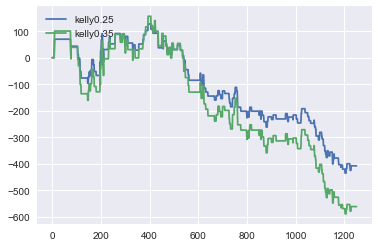

In [62]:
# data['exchangeHomePrice'] = data['exchangeHomePrice'] + 0.1
# data['exchangeAwayPrice'] = data['exchangeAwayPrice'] + 0.1

def kellyProportionHome(row, edgeThreshold):
    if row['538home'] - edgeThreshold > row['exchangeHomePercent']:
        return (row['538home'] * row['exchangeHomePrice'] - (1 - row['538home'])) / row['exchangeHomePrice'] 
    else:
        return 0

def kellyProportionAway(row, edgeThreshold):
    if row['538away'] - edgeThreshold > row['exchangeAwayPercent']:
        return (row['538away'] * row['exchangeAwayPrice'] - (1 - row['538away'])) / row['exchangeAwayPrice'] 
    else:
        return 0

def runBets(data, bankroll, kellyFraction):
    for index, row in data.iterrows():
        winnings = 0
        betSize = 0
        if row.kellyProportionHome > row.kellyProportionAway:
            # home bet
            betSize = customRound(min(row.kellyProportionHome * kellyFraction * bankroll, bankroll*0.05))
            if row.homeTeamWin:
                winnings = betSize * row.exchangeHomePrice
            else: 
                winnings = -1 * betSize
            data.loc[index, 'betTeam'] = 'home'
        elif row.kellyProportionAway > 0:
            # away bet
            betSize = customRound(min(row.kellyProportionAway * kellyFraction * bankroll, bankroll*0.05))
            if row.homeTeamWin == 0:
                winnings = betSize * row.exchangeAwayPrice
            else: 
                winnings = -1 * betSize
            data.loc[index, 'betTeam'] = 'away'
        data.loc[index, 'betSize'] = betSize
        data.loc[index, 'winnings'] = winnings
        data.loc[index, 'return'] = winnings / bankroll
        bankroll = bankroll + winnings 
    return data


data['kellyProportionHome'] = data.apply(lambda row: kellyProportionHome(row, edgeThreshold), axis=1)
data['kellyProportionAway'] = data.apply(lambda row: kellyProportionAway(row, edgeThreshold), axis=1)

for i in range(2,4, 1):
    print('generating fractional kelly returns... fraction: ' + str(i/10))
    temp_data = runBets(data, bankroll, i/10)
    temp_data.to_csv('./' + str(i) + '_538.csv')
    print('mean return: ', data['return'].mean())
    print('std of returns: ', data['return'].std())
    plt.plot(temp_data['winnings'].cumsum(), label='kelly' + str((i+0.5)/10))
    
plt.legend(loc='upper left')
plt.show()

### betting strategy recent record
make a fractional kelly bet wherever recent record (wins in last X) implies a win prob >= edgeThreshold vs best exchange price for a particular team/game combination 

In [63]:
# MODEL PARAMETERISATION 
edgeThreshold = 0.04
bankroll = 1000
# kellyFraction = 0.5

In [ ]:
def kellyProportionHome(row, edgeThreshold):
    if row['homeProb'] - edgeThreshold > row['exchangeHomePercent']:
        return (row['homeProb'] * row['exchangeHomePrice'] - (1 - row['homeProb'])) / row['exchangeHomePrice'] 
    else:
        return 0

def kellyProportionAway(row, edgeThreshold):
    if row['awayProb'] - edgeThreshold > row['exchangeAwayPercent']:
        return (row['awayProb'] * row['exchangeAwayPrice'] - (1 - row['awayProb'])) / row['exchangeAwayPrice'] 
    else:
        return 0

def runBets(data, bankroll, kellyFraction):
    for index, row in data.iterrows():
        winnings = 0
        betSize = 0
        if row.kellyProportionHome > 0:
            betSize = row.kellyProportionHome * kellyFraction * bankroll
            if row.homeTeamWin:
                winnings = betSize * row.exchangeHomePrice
            else: 
                winnings = -1 * betSize
        if row.kellyProportionAway > 0:
            betSize = row.kellyProportionAway * kellyFraction * bankroll
            if row.homeTeamWin == 0:
                winnings = betSize * row.exchangeAwayPrice
            else: 
                winnings = -1 * betSize
        
        data.loc[index, 'winnings'] = winnings
        data.loc[index, 'return'] = winnings / bankroll
        bankroll = bankroll + winnings 
    return data

# last 10 win/loss ratio

def homeWinsInLast10(row):
    previousGames = data[((data['awayTeamId'] == row['homeTeamId']) | (data['homeTeamId'] == row['homeTeamId'])) 
        & (data['id'] < row['id'])].tail(10)
    wins = previousGames[((previousGames['homeTeamId'] == row['homeTeamId']) & (previousGames['homeTeamWin'] == 1)) |
                        ((previousGames['awayTeamId'] == row['homeTeamId']) & (previousGames['homeTeamWin'] == 0))]
    return len(wins.index) / 10

def awayWinsInLast10(row):
    previousGames = data[((data['awayTeamId'] == row['awayTeamId']) | (data['homeTeamId'] == row['awayTeamId'])) 
        & (data['id'] < row['id'])].tail(10)
    wins = previousGames[((previousGames['homeTeamId'] == row['awayTeamId']) & (previousGames['homeTeamWin'] == 1)) |
                        ((previousGames['awayTeamId'] == row['awayTeamId']) & (previousGames['homeTeamWin'] == 0))]
    return len(wins.index) / 10

print('calculating recent records...')
data['homeWinsInLast10'] = data.apply(homeWinsInLast10, axis=1)
data['awayWinsInLast10'] = data.apply(awayWinsInLast10, axis=1)
print('calcs done...')

# home power is share of total last 10 wins
data['homeProb'] = data['homeWinsInLast10'] / (data['homeWinsInLast10'] + data['awayWinsInLast10']) + 0.1
data['awayProb'] = data['awayWinsInLast10'] / (data['homeWinsInLast10'] + data['awayWinsInLast10']) - 0.1

# ignore first 10 rows
data = data[10:]

print('calculating bet sizes...')
data['kellyProportionHome'] = data.apply(lambda row: kellyProportionHome(row, edgeThreshold), axis=1)
data['kellyProportionAway'] = data.apply(lambda row: kellyProportionAway(row, edgeThreshold), axis=1)

print('running bets...')
# running bets for kellyFraction = 0.1,...,1
for i in range(1,10, 1):
    print('generating fractional kelly returns... fraction: ' + str(i/10))
    temp_data = runBets(data, bankroll, i/10)
    print('mean: ', data['return'].mean())
    print('stdev: ', data['return'].std())
    plt.plot(temp_data['winnings'].cumsum(), label='kelly' + str(i/10))

# data.to_csv('./538strat.csv')
print('all bets ran...')

print('visualizing...')
plt.legend(loc='upper right')
plt.show()

calculating recent records...
calcs done...
calculating bet sizes...


/Users/laurenceholmes/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/laurenceholmes/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


running bets...
generating fractional kelly returns... fraction: 0.1


/Users/laurenceholmes/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
